# 5. Neural Networks with PyTorch

### 1. Prepare data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/titanic.csv")
cols = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Survived"]
df = df[cols]
df = df.dropna()

In [3]:
X = df.drop("Survived", axis=1)
X = pd.get_dummies(X, columns=["Sex", "Embarked"], dtype=float) 
y = df["Survived"]

In [4]:
X.dtypes

Pclass          int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Sex_female    float64
Sex_male      float64
Embarked_C    float64
Embarked_Q    float64
Embarked_S    float64
dtype: object

In [5]:
from sklearn.model_selection import train_test_split

X = X.values # convert df to numpy-array
y = y.values # convert df to numpy-array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

###  2. Model Training

In [6]:
import torch
torch.manual_seed(0)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
train_x = torch.Tensor(X_train).float().to(device)
test_x = torch.Tensor(X_test).float().to(device)
train_y = torch.Tensor(y_train).long().to(device)
test_y = torch.Tensor(y_test).long().to(device)

In [9]:
import torch.nn as nn

class DeepNeuralNetwork(nn.Module): # the class has to inherent from nn.Module
    def __init__(self):
        
        super(DeepNeuralNetwork, self).__init__()  # calling super constructor
        
        # defining layers
        self.hidden1 = nn.Linear(10, 15)
        self.output = nn.Linear(15, 2)

    def forward(self, x):
        
        x = self.hidden1(x)
        x = torch.relu(x)
        x = self.output(x)

        return x

In [10]:
import time

dnn = DeepNeuralNetwork()
dnn.to(device)            # copy the model to the device 
dnn.train()      # set model into training mode

no_epochs = 200
learning_rate = 0.001

loss_func = nn.CrossEntropyLoss()  

optimizer = torch.optim.SGD(dnn.parameters(), lr=learning_rate)

start_time = time.time()
losses = []
for iteration in range(no_epochs):
    
    optimizer.zero_grad()
    y_hat = dnn(train_x) # we predict on all data points (= batch gradient descent)
    
    loss = loss_func(y_hat, train_y) # calculate the loss
    loss.backward() # backpropagate the loss to calculate gradients
    optimizer.step() # update the weights using these gradients 

    losses.append(loss.item())
    if iteration % 20 == 0:
        print(f"Loss in epoch {iteration} is {loss.item()}")

Loss in epoch 0 is 3.1980836391448975
Loss in epoch 20 is 0.7244585156440735
Loss in epoch 40 is 0.6581029891967773
Loss in epoch 60 is 0.6459795236587524
Loss in epoch 80 is 0.6381316184997559
Loss in epoch 100 is 0.6319767832756042
Loss in epoch 120 is 0.6269999742507935
Loss in epoch 140 is 0.6227624416351318
Loss in epoch 160 is 0.6191654205322266
Loss in epoch 180 is 0.6161312460899353


Text(0, 0.5, 'loss')

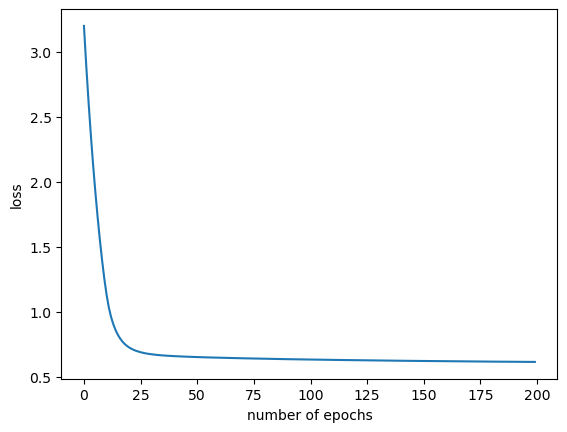

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(0, no_epochs), losses)
plt.xlabel('number of epochs')
plt.ylabel('loss')

After the network is trained, we can use it to predict on the test data.

In [12]:
dnn.eval() # set network to evaluation mode
y_pred = dnn(test_x)
predicted = torch.argmax(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
print(f"Accuarcy is {100. * correct / len(test_x)}%")

Accuarcy is 66.43356643356644%


### 3. Check for overfitting

In [13]:
import time

dnn = DeepNeuralNetwork()
dnn.to(device)            # copy the model to the device 
dnn.train()      # set model into training mode

no_epochs = 200
learning_rate = 0.001

loss_func = nn.CrossEntropyLoss()  

optimizer = torch.optim.SGD(dnn.parameters(), lr=learning_rate)

start_time = time.time()
losses = []
train_acc = []
test_acc = []

for iteration in range(no_epochs):
    
    optimizer.zero_grad()
    y_hat = dnn(train_x) # we predict on all data points (= batch gradient descent)
    
    loss = loss_func(y_hat, train_y) # calculate the loss
    loss.backward() # backpropagate the loss to calculate gradients
    optimizer.step() # update the weights using these gradients 

    losses.append(loss.item())
    
    with torch.no_grad(): # temporarily deactivates autograd engine
        
        dnn.eval()
        # accuracy on train
        y_hat = dnn(train_x)
        predicted = torch.argmax(y_hat.data, 1)
        correct = (predicted == train_y).sum().item()
        accuracy_train = 100. * correct / len(train_x)
        train_acc.append(accuracy_train)
        
        # accuracy on test
        y_hat = dnn(test_x)
        predicted = torch.argmax(y_hat.data, 1)
        correct = (predicted == test_y).sum().item()
        accuracy_test = 100. * correct / len(test_x)
        test_acc.append(accuracy_test)
        
        dnn.train() 
        
    if iteration % 20 == 0:
        print(f"Loss in epoch {iteration} is {loss.item()}")

Loss in epoch 0 is 2.623772382736206
Loss in epoch 20 is 0.7293772101402283
Loss in epoch 40 is 0.6793914437294006
Loss in epoch 60 is 0.6425702571868896
Loss in epoch 80 is 0.6233569383621216
Loss in epoch 100 is 0.612875759601593
Loss in epoch 120 is 0.6066220998764038
Loss in epoch 140 is 0.6031623482704163
Loss in epoch 160 is 0.6011450886726379
Loss in epoch 180 is 0.5998067855834961


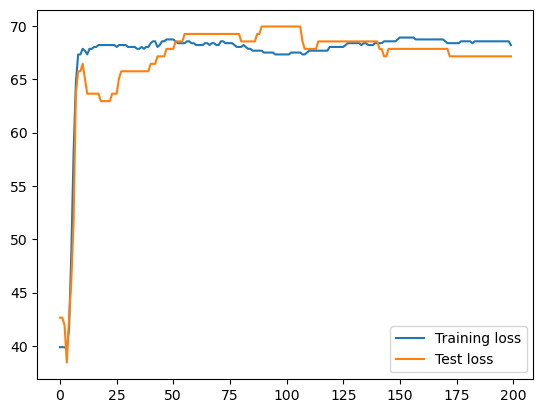

In [14]:
plt.plot(train_acc, label= "Training loss")
plt.plot(test_acc, label= "Test loss")
plt.legend()